In [1]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [2]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 600 files belonging to 2 classes.


In [3]:
data_iterator = data.as_numpy_iterator()

In [4]:
batch = data_iterator.next()

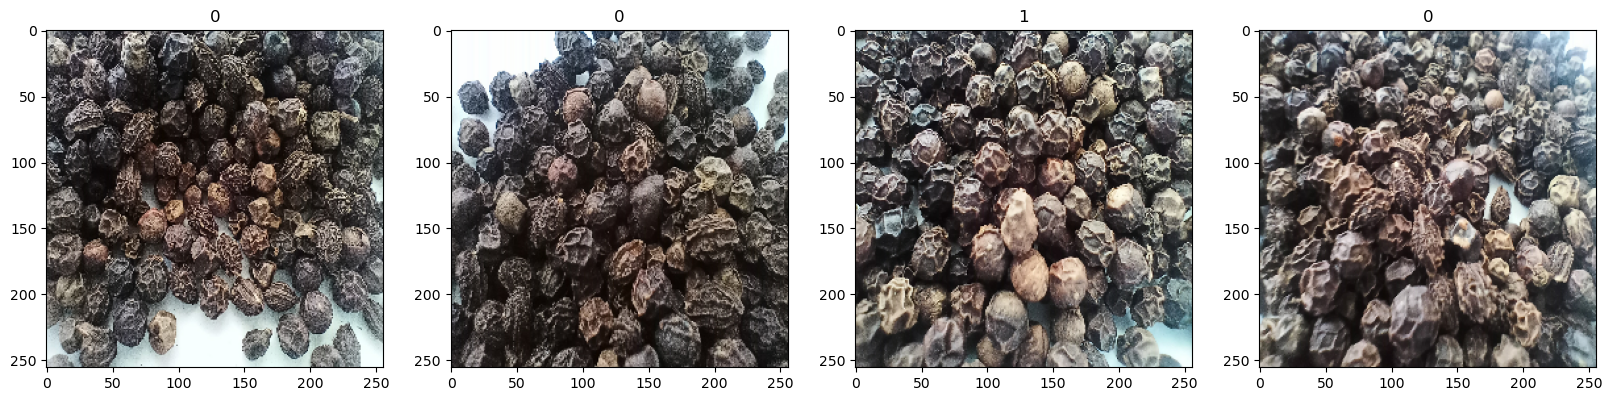

In [5]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [6]:
data = data.map(lambda x, y: (x / 255, y))
data = data.map(lambda x, y: (tf.image.resize(x, (224, 224)), y))

In [7]:
train_size = int(len(data)*.8)
val_size = int(len(data)*.1)
test_size = int(len(data)*.1)

In [8]:
train_size

15

In [9]:
val_size

1

In [10]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [11]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image, label

In [12]:
train = train.map(augment_image)

In [13]:
train

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
model = Sequential()

In [15]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
logdir='logs'

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [20]:
hist = model.fit(
    train,
    validation_data=val,
    verbose=1,
    epochs=50,
    callbacks = [tensorboard_callback, early_stopping]
)

Epoch 1/50


15/15 [==============================] - 73s 4s/step - loss: 1.1536 - accuracy: 0.5813 - val_loss: 0.6370 - val_accuracy: 0.7500
Epoch 2/50
15/15 [==============================] - 55s 4s/step - loss: 0.8126 - accuracy: 0.6938 - val_loss: 0.6376 - val_accuracy: 0.7812
Epoch 3/50
15/15 [==============================] - 55s 3s/step - loss: 0.6777 - accuracy: 0.6979 - val_loss: 0.6097 - val_accuracy: 0.8125
Epoch 4/50
15/15 [==============================] - 58s 4s/step - loss: 0.6175 - accuracy: 0.7437 - val_loss: 0.5650 - val_accuracy: 0.7500
Epoch 5/50
15/15 [==============================] - 63s 4s/step - loss: 0.6130 - accuracy: 0.7667 - val_loss: 0.5779 - val_accuracy: 0.8125
Epoch 6/50
15/15 [==============================] - 62s 4s/step - loss: 0.5997 - accuracy: 0.7375 - val_loss: 0.5779 - val_accuracy: 0.8125
Epoch 7/50
15/15 [==============================] - 60s 4s/step - loss: 0.5772 - accuracy: 0.7479 - val_loss: 0.5369 - val_accuracy: 0.8438
Epoch 8/50
15/15 [

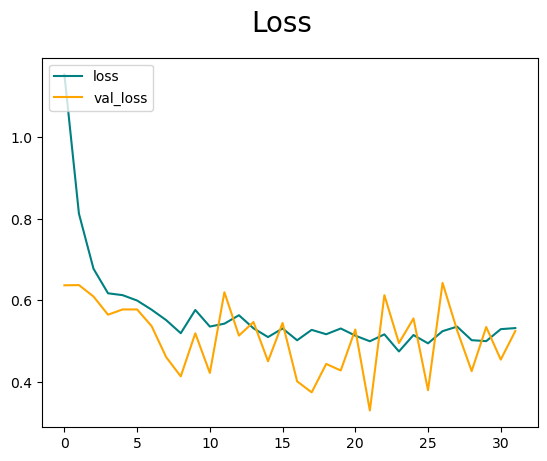

In [21]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

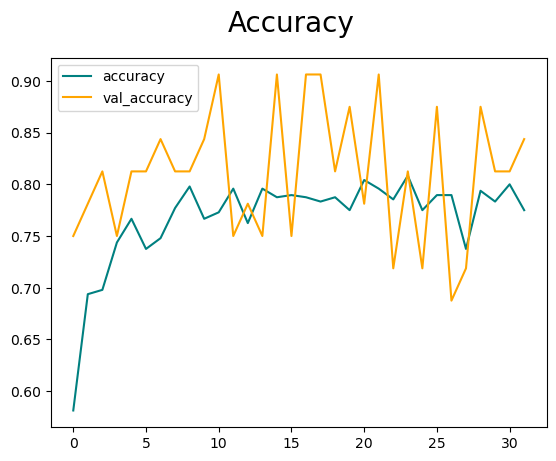

In [22]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [23]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, auc

In [24]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [25]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 4s 4s/step


In [26]:
precision = pre.result().numpy()
recall = re.result().numpy()
accuracy = acc.result().numpy()
f1 = 2 * (precision * recall) / (precision + recall)

In [27]:
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1)

Precision: 0.72727275
Recall: 0.9411765
Accuracy: 0.78125
F1 Score: 0.8205128534893554


In [28]:
true_labels = []
predicted_labels = []
for batch in test:
    X, y = batch
    y_pred = model.predict(X) > 0.5 # Using 0.5 as the threshold for binary classification
    true_labels.extend(y.numpy())
    predicted_labels.extend(y_pred.astype(int))

1/1 [==============================] - 3s 3s/step


In [29]:
report = classification_report(true_labels, predicted_labels, target_names=['Adulterated', 'Pure'], digits=4)
print(report)

              precision    recall  f1-score   support

 Adulterated     0.8462    0.6471    0.7333        17
        Pure     0.6842    0.8667    0.7647        15

    accuracy                         0.7500        32
   macro avg     0.7652    0.7569    0.7490        32
weighted avg     0.7702    0.7500    0.7480        32



In [30]:
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[11  6]
 [ 2 13]]


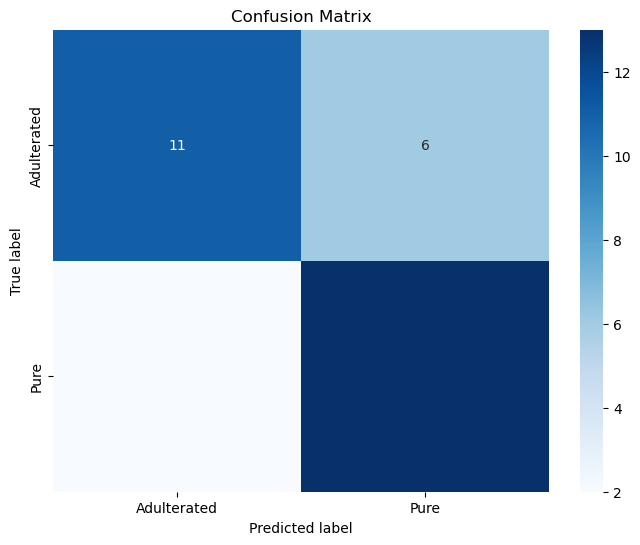

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Adulterated', 'Pure'], yticklabels=['Adulterated', 'Pure'],
            annot_kws={"fontsize": 10})
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

Area Under Curve (AUC): 0.806688596491228


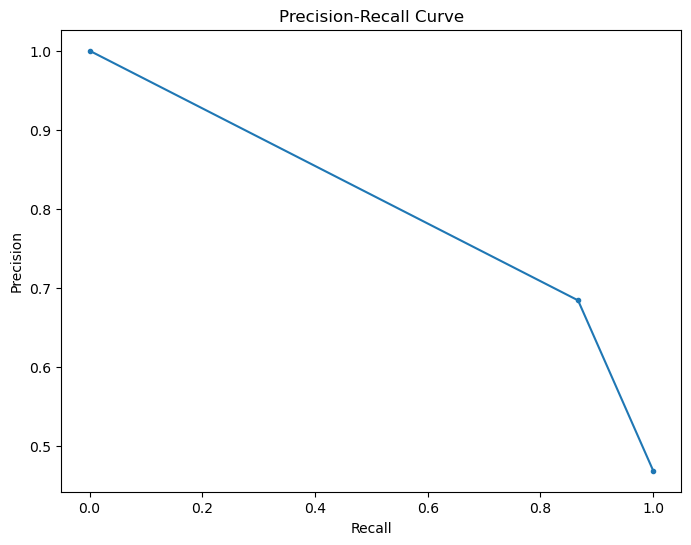

In [32]:
precision, recall, _ = precision_recall_curve(true_labels, predicted_labels)
area_under_curve = auc(recall, precision)

print("Area Under Curve (AUC):", area_under_curve)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

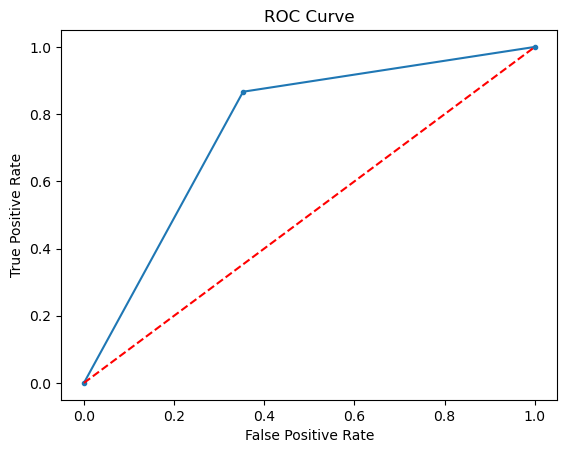

FPR: 0.0, TPR: 0.0
FPR: 0.35294117647058826, TPR: 0.8666666666666667
FPR: 1.0, TPR: 1.0


In [33]:
from sklearn.metrics import roc_curve
# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Compute ROC curve
fpr, tpr, _ = roc_curve(true_labels, predicted_labels)

# Plot ROC curve
ax.plot(fpr, tpr, marker='.')
ax.plot([0, 1], [0, 1], linestyle='--', color='red')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')

# Show the plot
plt.show()
for i in range(len(fpr)):
    print(f"FPR: {fpr[i]}, TPR: {tpr[i]}")

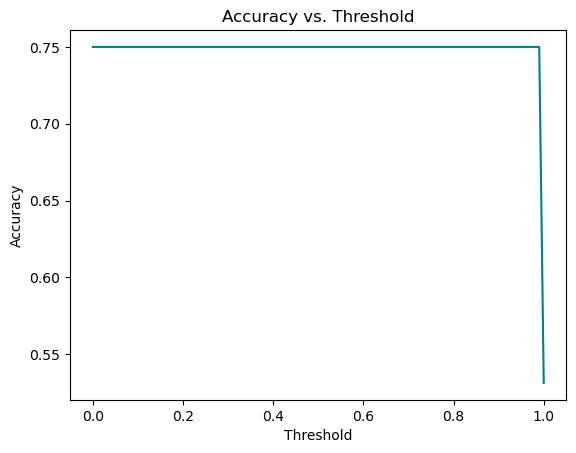

Threshold: 0.00, Accuracy: 0.7500
Threshold: 0.01, Accuracy: 0.7500
Threshold: 0.02, Accuracy: 0.7500
Threshold: 0.03, Accuracy: 0.7500
Threshold: 0.04, Accuracy: 0.7500
Threshold: 0.05, Accuracy: 0.7500
Threshold: 0.06, Accuracy: 0.7500
Threshold: 0.07, Accuracy: 0.7500
Threshold: 0.08, Accuracy: 0.7500
Threshold: 0.09, Accuracy: 0.7500
Threshold: 0.10, Accuracy: 0.7500
Threshold: 0.11, Accuracy: 0.7500
Threshold: 0.12, Accuracy: 0.7500
Threshold: 0.13, Accuracy: 0.7500
Threshold: 0.14, Accuracy: 0.7500
Threshold: 0.15, Accuracy: 0.7500
Threshold: 0.16, Accuracy: 0.7500
Threshold: 0.17, Accuracy: 0.7500
Threshold: 0.18, Accuracy: 0.7500
Threshold: 0.19, Accuracy: 0.7500
Threshold: 0.20, Accuracy: 0.7500
Threshold: 0.21, Accuracy: 0.7500
Threshold: 0.22, Accuracy: 0.7500
Threshold: 0.23, Accuracy: 0.7500
Threshold: 0.24, Accuracy: 0.7500
Threshold: 0.25, Accuracy: 0.7500
Threshold: 0.26, Accuracy: 0.7500
Threshold: 0.27, Accuracy: 0.7500
Threshold: 0.28, Accuracy: 0.7500
Threshold: 0.2

In [34]:
thresholds = np.arange(0, 1.01, 0.01)
predicted_labels = np.array(predicted_labels)
accuracies = [np.mean((predicted_labels.ravel().astype(bool) > threshold) == true_labels) for threshold in thresholds]
plt.plot(thresholds, accuracies, color='teal')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold')
plt.show()
for threshold, accuracy in zip(thresholds, accuracies):
    print(f'Threshold: {threshold:.2f}, Accuracy: {accuracy:.4f}')

In [35]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [36]:
import cv2

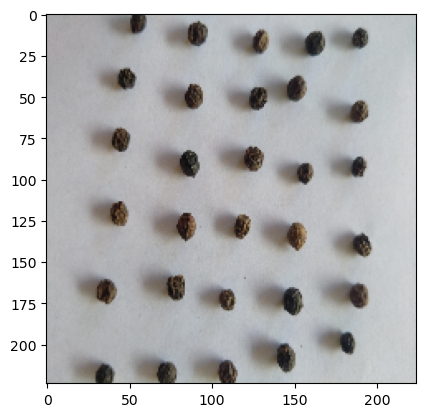

1/1 [==============================] - 0s 167ms/step
[[0.85379916]]
Predicted class is Pure with confidence level 0.85


In [127]:
img = cv2.imread('Test/Pure/25.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

# Predict the class probabilities
yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)

# Get the predicted class and confidence level
threshold = 0.5
predicted_class = 'Pure' if yhat[0] > threshold else 'Adulterated'
confidence_level = float(yhat[0][0]) if yhat[0] > threshold else 1 - float(yhat[0][0])
print(f'Predicted class is {predicted_class} with confidence level {confidence_level:.2f}')

In [128]:
if yhat[0] >= 0.5:
    confidence_level = (yhat[0] - 0.5) * 2 * 100  # Convert to percentage
else:
    confidence_level = (0.5 - yhat[0]) * 2 * 100  # Convert to percentage

# Get the predicted class
predicted_class = 'Pure' if yhat[0] >= 0.5 else 'Adulterated'

print(f'Predicted class is {predicted_class} with confidence level {confidence_level[0]:.2f}%')

Predicted class is Pure with confidence level 70.76%


In [38]:
from tensorflow.keras.models import load_model

In [39]:
model.save(os.path.join('models','VGG16.h5'))

C:\Users\rebab\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
loaded_model = load_model('models\VGG16.h5')

In [41]:
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()
with open('VGG16.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\rebab\AppData\Local\Temp\tmph_rs7uy5\assets


INFO:tensorflow:Assets written to: C:\Users\rebab\AppData\Local\Temp\tmph_rs7uy5\assets
